In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit

import transport_signal_processing as tsp
from data_manager import DataManager

## Select and load events

In [2]:
# parameters
path = "*"
level = 1
selected_only = True

# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)

# add full condition key
df['condition'] = df.apply(lambda x: "{}-{}-{}mV-{}C".format(x['analyte'], x['buffer'], x['voltage'], x['temperature']), axis=1)

# keep only selected segments
df = df[(df['selected'] > (level-1))]
df

,pore,temperature,voltage,analyte,buffer,channel,id,sid,segment_range,segment_duration,MODIFIED,mI_open,sI_open,N_events,N_cores,N_reduced,selected,ratio_sel,condition
0,K238A,25,100,AA00300AA,KCl,4,1,0,"[0, 16664623]",166.64623,2022-03-28_23:07:22,74.604682,3.383613,2724,1357.0,1357.0,1.0,0.601326,AA00300AA-KCl-100mV-25C
1,K238A,25,100,AA00300AA,KCl,4,2,0,"[0, 87199999]",871.99999,2022-03-28_23:07:22,73.243649,3.372951,18154,9296.0,9296.0,1.0,0.424053,AA00300AA-KCl-100mV-25C
9,K238A,25,100,AA00300AA,KCl,4,0-1,0,"[0, 36046911]",360.46911,2022-03-28_23:07:22,73.229070,3.101855,2713,1362.0,1362.0,1.0,0.544053,AA00300AA-KCl-100mV-25C
10,K238A,25,100,AA00300AA,KCl,4,0-2,0,"[0, 20216780]",202.16780,2022-03-28_23:07:22,73.655572,3.242013,1452,725.0,725.0,1.0,0.507586,AA00300AA-KCl-100mV-25C
12,K238A,20,100,AA00300AA,KCl,4,5,0,"[0, 91120591]",911.20591,2022-03-28_23:07:21,73.841823,3.388007,19972,8576.0,8576.0,1.0,0.602146,AA00300AA-KCl-100mV-20C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,K238A,5,100,AA00100AA,KCl,2,0,0,"[0, 29554457]",295.54457,2022-03-28_23:07:19,51.267985,2.389354,2264,971.0,971.0,1.0,0.958805,AA00100AA-KCl-100mV-5C
743,K238A,5,100,AA00100AA,KCl,2,0,1,"[29627168, 94125135]",644.97967,2022-03-28_23:07:19,51.237124,2.386652,8864,3679.0,3679.0,1.0,0.960587,AA00100AA-KCl-100mV-5C
744,K238A,5,100,AA00100AA,KCl,3,0,0,"[0, 29554457]",295.54457,2022-03-28_23:07:19,65.268066,3.801594,3416,1596.0,1596.0,1.0,0.937343,AA00100AA-KCl-100mV-5C
746,K238A,5,100,AA00100AA,KCl,4,0,0,"[0, 29554457]",295.54457,2022-03-28_23:07:19,51.027371,2.706328,3687,1555.0,1555.0,1.0,0.967846,AA00100AA-KCl-100mV-5C


In [3]:
# parameters
key_sel = 'condition'

# load stats grouped by selected key
stats_dict = tsp.utils.load_stats_for_key(sigman, df.to_dict('records'), key_sel, selected_only=selected_only)

# find keys
key_sels = np.unique(df[key_sel].values)

events_dict = {}
for key in tqdm(key_sels):
    # subset
    dfs = df[df[key_sel] == key].copy()

    # load core events
    events_dict[key] = tsp.utils.load_core_events(sigman, dfs.to_dict('record'), selected_only=selected_only)
    #tsp.utils.load_reduced_events(sigman, dfs.to_dict('record'), selected_only=selected_only)

  0%|          | 0/69 [00:00<?, ?it/s]/home/lfkrapp/anaconda3/envs/tsp/lib/python3.9/site-packages/pandas/core/frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


In [4]:
def exp_fct(x, a, b):
    return a*np.exp(-b*x)

def exp_dist_fit(t, xlims, bins):
    # dwell time fit
    h, dwt = np.histogram(t, range=xlims, bins=bins)
    #h = h / np.sum(h)
    dwt = 0.5*(dwt[:-1] + dwt[1:])

    i0, i1 = np.argmax(h), np.argmin(h)
    i1 = len(h)-1
    xv = dwt[i0:i1]
    yv = h[i0:i1] # / np.max(h[i0:i1])

    popt, pcov = curve_fit(exp_fct, xv, yv, p0=(1.0,0.1))

    x = np.linspace(dwt[i0], dwt[i1])
    y = exp_fct(x, popt[0], popt[1])

    a = popt[1]
    err = np.sqrt(pcov[1][1])/np.square(popt[1])
    
    return x, y, a, err

In [5]:
def gauss_fct(x, A, mu, sigma):
    return np.abs(A) * np.exp(-np.square((x - mu))/np.square(sigma))

def gauss_dist_fit(t, xlims, bins):
    # dwell time fit
    h, dwt = np.histogram(t, range=xlims, bins=bins)
    #h = h / np.sum(h)
    dwt = 0.5*(dwt[:-1] + dwt[1:])

    i0, i1 = np.argmax(h), np.argmin(h)
    i1 = len(h)-1
    xv = dwt[i0:i1]
    yv = h[i0:i1] # / np.max(h[i0:i1])

    popt, pcov = curve_fit(gauss_fct, xv, yv, p0=(1.0,0.1,1.0))

    x = np.linspace(dwt[i0], dwt[i1])
    y = gauss_fct(x, popt[0], popt[1], popt[2])

    a = popt[1]
    err = np.sqrt(pcov[1,1])
    
    return x, y, np.power(10,a), np.log(10.0)*np.power(10,a)*err

## Conditions

In [6]:
key_sels = [
    # AA00100AA
    ## KCl (temperature)
    'AA00100AA-KCl-100mV-5C',
    'AA00100AA-KCl-100mV-10C',
    'AA00100AA-KCl-100mV-15C',
    'AA00100AA-KCl-100mV-20C',
    'AA00100AA-KCl-100mV-25C',
    'AA00100AA-KCl-100mV-30C',
    # ------------------------------------------------------------------------------
    # AA00000AA
    ## LiCl
    'AA00000AA-LiCl-100mV-25C',
    ## NaCl
    'AA00000AA-NaCl-100mV-25C',
    # ------------------------------------------------------------------------------
    # AA0000AA
    ## KCl (temperature)
    'AA0000AA-KCl-100mV-5C',
    'AA0000AA-KCl-100mV-15C',
    'AA0000AA-KCl-100mV-25C',
    ## LiCl
    'AA0000AA-LiCl-100mV-25C',
    ## NaCl (voltage)
    #'AA0000AA-NaCl-80mV-25C',
    'AA0000AA-NaCl-90mV-25C',
    'AA0000AA-NaCl-100mV-25C',
    'AA0000AA-NaCl-110mV-25C',
    'AA0000AA-NaCl-120mV-25C',
    'AA0000AA-NaCl-130mV-25C',
    # ------------------------------------------------------------------------------
    # AA00300AA
    ## KCl (temprature 100mv)
    'AA00300AA-KCl-100mV-0C',
    'AA00300AA-KCl-100mV-5C',
    'AA00300AA-KCl-100mV-10C',
    'AA00300AA-KCl-100mV-15C',
    'AA00300AA-KCl-100mV-20C',
    'AA00300AA-KCl-100mV-25C',
    ## KCl (temperature 110mv)
    'AA00300AA-KCl-110mV-5C',
    'AA00300AA-KCl-110mV-10C',
    'AA00300AA-KCl-110mV-20C',
    'AA00300AA-KCl-110mV-25C',
    ## KCl (temperature 120mv)
    'AA00300AA-KCl-120mV-5C',
    'AA00300AA-KCl-120mV-10C',
    'AA00300AA-KCl-120mV-20C',
    'AA00300AA-KCl-120mV-25C',
    ## KCl (temperature 90mv)
    'AA00300AA-KCl-90mV-10C',
    'AA00300AA-KCl-90mV-20C',
    'AA00300AA-KCl-90mV-25C',
    ## KCl (temperature 130mv)
    'AA00300AA-KCl-130mV-5C',
    'AA00300AA-KCl-130mV-10C',
    'AA00300AA-KCl-130mV-20C',
    'AA00300AA-KCl-130mV-25C',
    ## LiCl (temperature 90mv)
    'AA00300AA-LiCl-90mV-10C',
    'AA00300AA-LiCl-90mV-15C',
    'AA00300AA-LiCl-90mV-25C',
     ## LiCl (temperature 100mv)
    'AA00300AA-LiCl-100mV-0C',
    'AA00300AA-LiCl-100mV-10C',
    'AA00300AA-LiCl-100mV-15C',
    'AA00300AA-LiCl-100mV-20C',
    'AA00300AA-LiCl-100mV-25C',
     ## LiCl (temperature 110mv)
    'AA00300AA-LiCl-110mV-10C',
    'AA00300AA-LiCl-110mV-15C',
    'AA00300AA-LiCl-110mV-25C',
     ## LiCl (temperature 120mv)
    'AA00300AA-LiCl-120mV-15C',
    'AA00300AA-LiCl-120mV-20C',
    'AA00300AA-LiCl-120mV-25C',
    ## LiCl (temperature 130mv)
    'AA00300AA-LiCl-130mV-10C',
    'AA00300AA-LiCl-130mV-15C',
    ## LiCl (temperature 130mv)
    'AA00300AA-LiCl-140mV-10C',
    'AA00300AA-LiCl-140mV-15C',
    ## LiCl (temperature 140mv)
    'AA00300AA-LiCl-140mV-10C',
    'AA00300AA-LiCl-140mV-15C',
    ## NaCl (temperature 100mv)
    'AA00300AA-NaCl-100mV-0C',
    'AA00300AA-NaCl-100mV-5C',
    'AA00300AA-NaCl-100mV-10C',
    'AA00300AA-NaCl-100mV-15C',
    'AA00300AA-NaCl-100mV-20C',
    'AA00300AA-NaCl-100mV-25C',
    ## NaCl (temperature 120mv)
    'AA00300AA-NaCl-120mV-0C',
    'AA00300AA-NaCl-120mV-25C',
    ## NaCl (temperature 140mv)
    'AA00300AA-NaCl-140mV-0C',
    'AA00300AA-NaCl-140mV-25C',
    ## RbCl
    'AA00300AA-RbCl-100mV-25C',
    ## 60NaCl-40LiCl (voltage)
    'AA00300AA_60NaCl-40LiCl-80mV-25C',
    'AA00300AA_60NaCl-40LiCl-100mV-25C',
    'AA00300AA_60NaCl-40LiCl-120mV-25C',
]

## Multilevel analysis

In [7]:
def steps_detection(I, ws=5, n_iters=256):
    # envelope iterative smoothing
    Is = I.copy()
    for k in range(n_iters):
        Imax, Imin = tsp.signals.envelope(Is, ws)
        Is = 0.5*(Imax + Imin)

    # steps location
    ids_step = np.where(np.abs(np.diff(np.sign(np.diff(Is)))) > 0.5)[0]

    # steps amplitudes
    dI = np.abs(np.diff(Is[ids_step]))
    
    return Is, ids_step, dI

In [54]:
#key = 'AA00100AA-KCl-100mV-25C'
#key = 'AA00300AA-KCl-110mV-5C'
#key = 'AA00300AA-KCl-110mV-10C'
key = 'AA00300AA-KCl-110mV-15C'
#key = 'AA00300AA-KCl-110mV-20C'
#key = 'AA00300AA-KCl-110mV-25C'
#key = 'AA00300AA-KCl-100mV-5C' not_working
#key = 'AA00300AA-KCl-100mV-10C'
#key = 'AA00300AA-KCl-100mV-15C'
#key = 'AA00300AA-KCl-100mV-20C'
#key = 'AA00300AA-KCl-100mV-25C'
#key = 'AA00300AA-KCl-90mV-5C' not_working
#key = 'AA00300AA-KCl-90mV-10C'
#key = 'AA00300AA-KCl-90mV-15C'not_working
#key = 'AA00300AA-KCl-90mV-20C'
#key = 'AA00300AA-KCl-90mV-25C'
#key = 'AA00300AA-KCl-120mV-5C'
#key = 'AA00300AA-KCl-120mV-10C'
#key = 'AA00300AA-KCl-120mV-15C'not_working
#key = 'AA00300AA-KCl-120mV-20C'
#key = 'AA00300AA-KCl-120mV-25C'
#key = 'AA00300AA-KCl-130mV-5C'
#key = 'AA00300AA-KCl-130mV-10C'
#key = 'AA00300AA-KCl-130mV-15C'not_working
#key = 'AA00300AA-KCl-130mV-20C'
#key = 'AA00300AA-KCl-130mV-25C'
#key = 'AA00300AA-NaCl-100mV-25C'
#key = 'AA00300AA-NaCl-100mV-0C'not_working
#key = 'AA00300AA-NaCl-100mV-5C'
#key = 'AA00300AA-NaCl-100mV-10C'
#key = 'AA00300AA-NaCl-100mV-15C'
#key = 'AA00300AA-NaCl-100mV-20C'
#key = 'AA00300AA-NaCl-100mV-25C' badfit
#key = 'AA00300AA-NaCl-120mV-0C'
#key = 'AA00300AA-NaCl-120mV-25C'not work
#key = 'AA00300AA-NaCl-140mV-0C'
#key = 'AA00300AA-NaCl-140mV-25C' not work
#key = 'AA00300AA-RbCl-100mV-25C'
events = events_dict[key]

KeyError: 'AA00300AA-KCl-110mV-15C'

In [55]:
I_all = np.concatenate([evt[:,1] for evt in events])

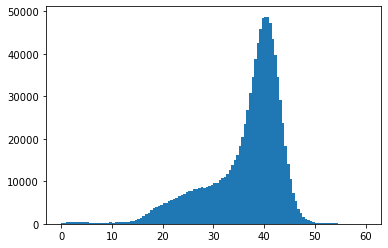

In [56]:
plt.figure()
plt.hist(I_all, range=(0.0, 60.0), bins=120)
plt.show()

i = 575


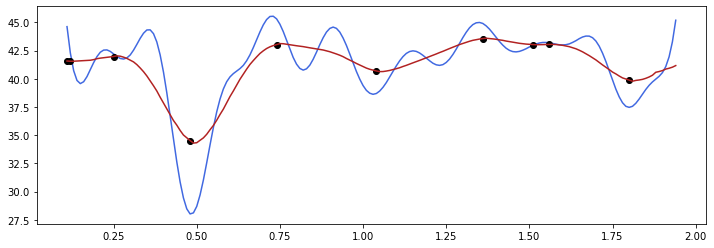

In [57]:
# parameters
ws = 3
n_iters = 8

# random choice
i = np.random.choice(len(events))
print("i = {}".format(i))
#i = 432

# step detection
evt = events[i]
t = evt[:,0]
I = evt[:,1]
Is, ids_step, dI = steps_detection(I, ws=ws, n_iters=n_iters)

# plot
plt.figure(figsize=(12,4))
plt.plot(t, I, '-', color='royalblue')
plt.plot(t[ids_step], Is[ids_step], 'ko')
plt.plot(t, Is, '-', color='firebrick')
plt.show()

100%|██████████| 2048/2048 [00:03<00:00, 651.04it/s]


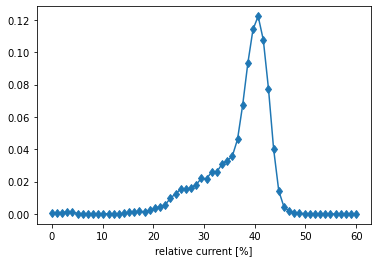

In [58]:
# parameters
ws = 3
n_iters = 8
xlims = (0.0, 60.0)
nbins = 60
N = 2048

# make global distribution
x = np.linspace(xlims[0], xlims[1], nbins)
h = np.zeros(nbins)
for i in tqdm(np.random.choice(len(events), N)):
#for i in tqdm(range(len(events))):
    # step detection
    evt = events[i]
    t = evt[:,0]
    I = evt[:,1]
    Is, ids_step, dI = steps_detection(I, ws=ws, n_iters=n_iters)
    
    # make histogram
    hi, _ = np.histogram(Is[ids_step], range=xlims, bins=nbins)
    h = h + hi / (np.sum(hi) + 1e-6)
    
# normalize
h = h / np.sum(h)

# plot
plt.figure()
plt.plot(x,h,'d-')
plt.xlabel('relative current [%]')
plt.show()

In [59]:
def levels_probabilites(x, popt_l):
    z_l = []
    for i in range(len(popt_l)):
        popt = popt_l[i]
        z_l.append(tsp.fits.gauss(x, popt[0], popt[1], popt[2]))
    
    return np.stack(z_l, axis=1)

def gauss(x, A, mu, sigma):
    return np.abs(A) * np.exp(-np.square((x - mu))/np.square(sigma))

def multi_gauss(x, *p):
    y = np.zeros(x.shape)
    for k in range(int(len(p) / 3)):
        y += gauss(x, p[3*k], p[3*k+1], p[3*k+2])

    return y

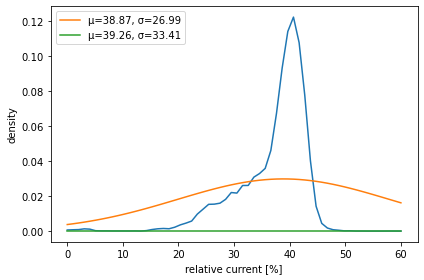

In [60]:
# parameters
guess = np.array(
    [0.5, 20.0, 10.0,
     0.5, 30.0, 10.0]
)
popt, pcov = curve_fit(multi_gauss, x.astype(np.float64), h.astype(np.float64), p0=guess.astype(np.float64))
popt_l = [popt[3*k:3*(k+1)] for k in range(2)]

plt.figure()
plt.plot(x,h)
for i in range(len(popt_l)):
    popt = popt_l[i]
    z = tsp.fits.gauss(x, popt[0], popt[1], popt[2])
    plt.plot(x,z,label="μ={:.2f}, σ={:.2f}".format(popt[1], popt[2]))
plt.legend(loc='best')
plt.xlabel("relative current [%]")
plt.ylabel("density")
plt.tight_layout()
plt.savefig("graphs/sublevels_fits_{}.png".format(key), dpi=200)
plt.show()

i = 1066


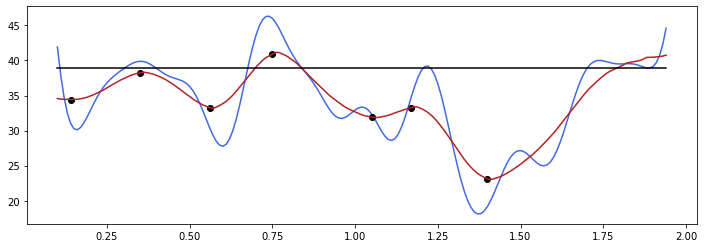

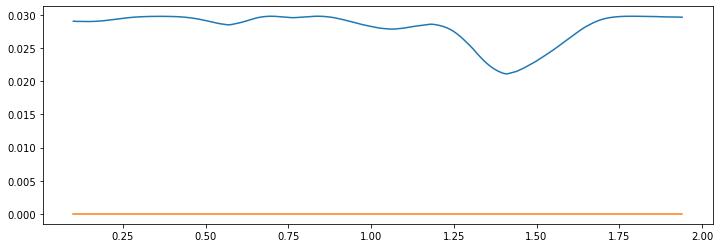

In [61]:
# parameters
ws = 3
n_iters = 8
a_thr = 0.6

# random choice
i = np.random.choice(len(events))
print("i = {}".format(i))
#i = 4519

# step detection
evt = events[i]
t = evt[:,0]
I = evt[:,1]
Is, ids_step, dI = steps_detection(I, ws=ws, n_iters=n_iters)

# probability
P = levels_probabilites(Is, popt_l)

# levels detection
ids_lvl = np.argmax(P, axis=1)
Il = np.array([popt[1] for popt in popt_l])[ids_lvl]

# plot
plt.figure(figsize=(12,4))
plt.plot(t, I, '-', color='royalblue')
plt.plot(t[ids_step], Is[ids_step], 'ko')
plt.plot(t, Is, '-', color='firebrick')
plt.plot(t, Il, '-', color='black')
plt.show()

plt.figure(figsize=(12,4))
for i in range(2):
    plt.plot(t, P[:,i])
    #p_thr = np.abs(popt_l[i][0])*a_thr
    #plt.plot([t[0], t[-1]], [p_thr, p_thr], 'k--')
#plt.plot(t, np.abs(np.diff(P, axis=1)))
plt.show()

In [62]:
# parameters
ws = 3
n_iters = 8
N = 2048

levels = []
#for i in tqdm(np.random.choice(len(events), N)):
for i in tqdm(range(len(events))):
    # step detection
    evt = events[i]
    t = evt[:,0]
    I = evt[:,1]
    Is, ids_step, dI = steps_detection(I, ws=ws, n_iters=n_iters)

    # probability
    P = levels_probabilites(Is, popt_l)

    # levels detection
    ids_lvl = np.argmax(P, axis=1)
    levels.append(ids_lvl)

100%|██████████| 1852/1852 [00:02<00:00, 681.48it/s]


In [63]:
# count levels
c_lvls = np.array([np.sum(np.abs(np.diff(ids_lvl)))+(1-ids_lvl[0])+(1-ids_lvl[-1]) for ids_lvl in levels])
h = np.bincount(c_lvls)[::2]
#h = h / np.sum(h)
h = h[:50]

nlvls = 2*np.arange(h.shape[0])+1

i0, i1 = np.argmax(h), np.argmin(h)
i1 = len(h)-1
xv = nlvls[i0:i1]
yv = h[i0:i1] # / np.max(h[i0:i1])

popt, pcov = curve_fit(exp_fct, xv, yv, p0=(1.0,0.1))

x = np.linspace(nlvls[i0], nlvls[i1])
y = exp_fct(x, popt[0], popt[1])

a = popt[1]
err = np.sqrt(pcov[1][1])/np.square(popt[1])

# figure
plt.figure()
plt.bar(np.arange(h.shape[0]), h)
plt.plot(0.5*(x-1),y, 'k-', label='N = {:.2f} ± {:.2f}'.format(1.0/a, err))
plt.xticks(np.arange(h.shape[0]), 2*np.arange(h.shape[0])+1)
plt.xlim(-0.5, 20.5)
plt.legend(loc='best')
plt.ylabel('count')
plt.xlabel('number of levels')
plt.tight_layout()
plt.savefig("graphs/sublevels_count_{}.png".format(key), dpi=200)
plt.show()

ValueError: `ydata` must not be empty!

In [ ]:
# parameters
max_dwt = 30.0  # ms

# correlate number of levels with event duration
dt = np.diff(events[0][:,0])[0]
l_lvls = np.array([ids_lvl.shape[0]*dt for ids_lvl in levels])

# maximum dwell time
m = ((l_lvls <= max_dwt) & (c_lvls > 1))

# linear fit
#a, b = np.polyfit(l_lvls[m], c_lvls[m], 1)
popt, pcov = curve_fit(lambda x,a: a*x, l_lvls[m], c_lvls[m], 1.0)
a = popt.item()
err = np.sqrt(pcov.item())

x = np.linspace(np.min(l_lvls[m]), np.max(l_lvls[m]))
y = a*x

# plot
plt.figure()
plt.plot(l_lvls[m], c_lvls[m], '.', ms=1.0)
plt.plot(x, y, 'k--', label='{:.2f} ± {:.2f}'.format(a,err))
plt.legend(loc='best')
plt.xlabel('dwell time [ms]')
plt.ylabel('number of levels')
plt.xlim(0.0, max_dwt)
plt.ylim(0.0, 70.0)
plt.tight_layout()
plt.savefig("graphs/sublevels_frequency_{}.png".format(key), dpi=200)
plt.show()

print("{:.2f} ± {:.2f} levels per ms".format(a, err))

In [ ]:
# extract currents and dwell times of levels
Ir_lvls = [[], []]
tr_lvls = [[], []]
for i in tqdm(range(len(levels))):
    ids_lvl = levels[i]
    if np.min(ids_lvl) != np.max(ids_lvl):
        # find levels ranges
        rng_high = tsp.signals.find_continuous_segments(np.where(ids_lvl > 0.5)[0])
        rng_low = tsp.signals.find_continuous_segments(np.where(ids_lvl < 0.5)[0])

        # extract currents and dwell times
        for rng in rng_high:
            Ir_lvls[0].append(events[i][rng[0]:rng[1]+1,1])
            tr_lvls[0].append(events[i][rng[1],0]-events[i][rng[0],0])

        for rng in rng_low:
            Ir_lvls[1].append(events[i][rng[0]:rng[1]+1,1])
            tr_lvls[1].append(events[i][rng[1],0]-events[i][rng[0],0])
        
# pack data
Ir_lvls = [np.array([np.mean(Ir) for Ir in Ir_l]) for Ir_l in Ir_lvls]
tr_lvls = [np.array(tr_l) for tr_l in tr_lvls]

In [ ]:
# parameters
xlims = (10.0, 50.0)
xlims_t = (0.0, 3.0)
xlims_l = (0.0, 2.0)
bins = 50
bins_t = 80
bins_l = 50

# plots
for k in range(len(Ir_lvls)):
    # gaussian fit
    h, Ih = np.histogram(Ir_lvls[k], range=xlims, bins=bins)
    Ih = 0.5*(Ih[:-1] + Ih[1:])

    z, popt = tsp.fits.multi_gauss_dist_fit(Ih, h)
    
    # plot
    plt.figure(figsize=(16,3))
    plt.subplot(131)
    plt.hist(Ir_lvls[k], range=xlims, bins=bins)
    plt.plot(Ih, z, 'k-', label='μ={:.1f}, σ={:.1f}'.format(popt[1], popt[2]))
    plt.xlim(xlims)
    plt.legend(loc='best')
    plt.xlabel('average relative current [%]')
    plt.ylabel('count')

    # exp dwell time fit
    x, y, a, dtau = exp_dist_fit(tr_lvls[k], xlims_t, bins_t)

    plt.subplot(132)
    plt.hist(tr_lvls[k], range=xlims_t, bins=bins_t)
    plt.plot(x,y, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(1.0/a, dtau))
    plt.xlim(0.0, 3.0)
    plt.legend(loc='best')
    plt.xlabel('dwell time [ms]')
    plt.ylabel('count')
    
    # log dwell time fit
    ldwt = np.log10(tr_lvls[k])
    x, y, a, dtau = gauss_dist_fit(ldwt, xlims_l, bins_l)
    
    plt.subplot(133)
    plt.hist(ldwt, range=xlims_l, bins=bins_l)
    plt.plot(x, y, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(a, dtau))
    plt.legend(loc='best')
    plt.xlabel('log10 dwell time [log10 ms]')
    plt.ylabel('count')
    plt.tight_layout()
    plt.savefig("graphs/sublevels_{}_N2_L{}.png".format(key,k), dpi=200)
    plt.show()